# Very Simple Linear Regression

Try a simple linear regression based model for predicting cross-domain correlation structures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [2]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')

### Quick look at correlations

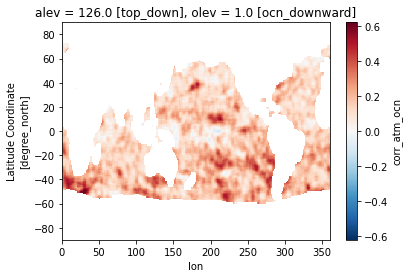

In [3]:
ds.corr_atm_ocn.isel(olev=0,alev=-1).plot()

## Prepare the data

### For now, just grab a few random variables to use...

Just as an example ... grabbing vector valued inputs from ocean, atmosphere, and scalars

In [4]:
ds['atm_speed_surf'] = ds['atm_wind_speed'].isel(alev=-1).drop('alev')

In [9]:
lbl = 'corr_atm_ocn'
chosen_ones = ['ocn_Temp',
               'atm_T',
               'ocn_MLD',
               'atm_speed_surf',
              ]

In [10]:
ds = ds[chosen_ones+[lbl, 'ocn_mask']]
ds

,Array,Chunk
Bytes,43.51 MiB,68.75 kiB
Shape,"(4, 44, 180, 360)","(4, 44, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,73.17 MiB,115.62 kiB
Shape,"(4, 74, 180, 360)","(4, 74, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### The output has more NaNs than the mask, so make a new mask

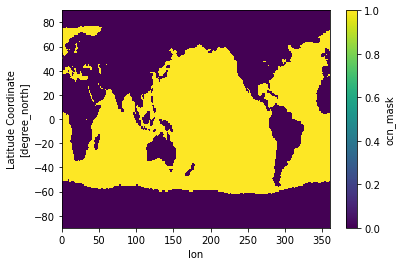

In [11]:
ds.ocn_mask.plot()

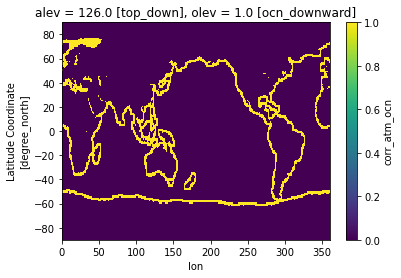

In [12]:
np.isnan(ds.corr_atm_ocn.where(ds.ocn_mask,0.).isel(alev=-1,olev=0)).plot()

In [13]:
ds['mask'] = ds.ocn_mask & ~np.isnan(ds.corr_atm_ocn).any(['alev','olev'])

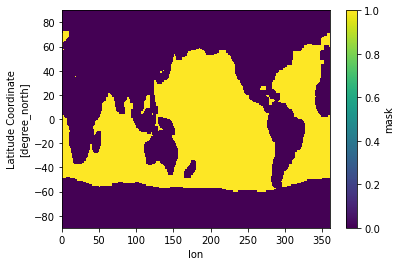

In [14]:
ds['mask'].plot()

### Stack lon/lat into single spatial dimension

Give this coordinate some trivial values so that xarray will plot without error

In [15]:
ds = ds.stack(x=('lat','lon')).reset_index('x')
ds['x'] = np.arange(len(ds.x))
ds

<xarray.Dataset>
Dimensions:         (member: 4, olev: 44, x: 64800, alev: 74)
Coordinates:
  * alev            (alev) float32 53.0 54.0 55.0 56.0 ... 124.0 125.0 126.0
  * member          (member) float64 9.5 29.5 49.5 69.5
  * olev            (olev) float32 1.0 3.0 5.0 7.0 ... 313.8 356.5 405.6 461.6
  * x               (x) int64 0 1 2 3 4 5 ... 64795 64796 64797 64798 64799
    lat             (x) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon             (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    ocn_Temp        (member, olev, x) float32 dask.array<chunksize=(4, 44, 360), meta=np.ndarray>
    atm_T           (member, alev, x) float32 dask.array<chunksize=(4, 74, 360), meta=np.ndarray>
    ocn_MLD         (member, x) float32 dask.array<chunksize=(4, 360), meta=np.ndarray>
    atm_speed_surf  (member, x) float32 dask.array<chunksize=(4, 360), meta=np.ndarray>
    corr_atm_ocn    (alev, olev, x) float32 dask.array<chunksize=(74, 44, 360), meta=np.ndarray>
    ocn_mask        (x) bool dask.array<chunksize=(360,), meta=np.ndarray>
    mask            (x) bool dask.array<chunksize=(360,), meta=np.ndarray>
Attributes:
    filename:  /work2/noaa/gsienkf/weihuang/WCLEKF_PRODFORECAST/2015120500000...
    title:     Atmosphere, Ocean and Ice combined data

### Remove NaNs

Note that it's easier to do this after stacking lon/lat -> x.
Otherwise, have to be more precise with the `drop` operations.

In [16]:
print(f"Num. spatial points: {len(ds.lon)*len(ds.lat)}")

Num. spatial points: 4199040000


In [17]:
%%time
ds = ds.where(ds['mask'], drop=True)

CPU times: user 22.8 s, sys: 4.2 s, total: 27 s
Wall time: 16.7 s


In [18]:
print(f"Num. spatial points after removing land and ice: {len(ds.x)}")

Num. spatial points after removing land and ice: 24754


In [19]:
np.isnan(ds.corr_atm_ocn).sum().values

array(0)

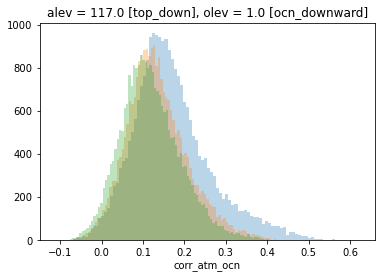

In [20]:
for alev in [-1, -5, -10]:
    ds.corr_atm_ocn.isel(olev=0,alev=alev).plot.hist(bins=100, alpha=.3);

### Broadcast correlation data to `member` dimension, and stack `sample = ("x", "member")`

This is a bit brute force, we're just copying the same label for each member.
There's probably a smarter way to do this.

In [32]:
ds[lbl] = ds[lbl].broadcast_like(ds.member)

In [36]:
ds = ds.stack(sample=("x","member"))

### Order dimensions, will come in handy later...

In [38]:
ds = ds.transpose('sample','olev','alev')
ds

<xarray.Dataset>
Dimensions:         (olev: 44, sample: 99016, alev: 74)
Coordinates:
  * alev            (alev) float32 53.0 54.0 55.0 56.0 ... 124.0 125.0 126.0
  * olev            (olev) float32 1.0 3.0 5.0 7.0 ... 313.8 356.5 405.6 461.6
    lat             (sample) float64 -59.5 -59.5 -59.5 -59.5 ... 72.5 72.5 72.5
    lon             (sample) float64 230.5 230.5 230.5 230.5 ... 9.5 9.5 9.5 9.5
  * sample          (sample) object MultiIndex
  * x               (sample) int64 11030 11030 11030 11030 ... 58329 58329 58329
  * member          (sample) float64 9.5 29.5 49.5 69.5 ... 9.5 29.5 49.5 69.5
Data variables:
    ocn_Temp        (sample, olev) float32 dask.array<chunksize=(80, 44), meta=np.ndarray>
    atm_T           (sample, alev) float32 dask.array<chunksize=(80, 74), meta=np.ndarray>
    ocn_MLD         (sample) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    atm_speed_surf  (sample) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    corr_atm_ocn    (sample, olev, alev) float32 dask.array<chunksize=(80, 44, 74), meta=np.ndarray>
    ocn_mask        (sample) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    mask            (sample) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Attributes:
    filename:  /work2/noaa/gsienkf/weihuang/WCLEKF_PRODFORECAST/2015120500000...
    title:     Atmosphere, Ocean and Ice combined data

### Separate into training and testing

Right now, only making this separation based on location, not separating samples.

TODO: fix this to play nicely with chunking if it becomes an issue

In [39]:
def random_indices(dim, fraction=0.8, random_seed=None):
    rstate = np.random.RandomState(random_seed)
    return rstate.choice(len(dim), size=int(len(dim)*fraction), replace=False)

def split_randomly(xds, dim='x', **kwargs):
    indices = random_indices(xds[dim], **kwargs)
    
    all_indices = np.arange(len(xds[dim]))
    others = np.array([i for i in all_indices if i not in indices])
    subset1 = xds.isel({dim:indices})
    subset2 = xds.isel({dim:others})
    return subset1, subset2
    

In [41]:
trainer, tester = split_randomly(ds, dim="sample")

/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 591 times more chunks
  return self.array[key]


### Split out labels and features/predictors

In [42]:
train_features = trainer.drop(lbl)
test_features = tester.drop(lbl)

train_labels = trainer[lbl]
test_labels = tester[lbl]

In [43]:
train_features['ocn_Temp']

<xarray.DataArray 'ocn_Temp' (sample: 79212, olev: 44)>
dask.array<getitem, shape=(79212, 44), dtype=float32, chunksize=(3, 44), chunktype=numpy.ndarray>
Coordinates:
  * olev     (olev) float32 1.0 3.0 5.0 7.0 9.005 ... 313.8 356.5 405.6 461.6
    lat      (sample) float64 -50.5 6.5 72.5 7.5 ... -45.5 12.5 -16.5 -23.5
    lon      (sample) float64 220.5 203.5 2.5 243.5 ... 59.5 304.5 200.5 169.5
  * sample   (sample) object MultiIndex
  * x        (sample) int64 14260 34763 58322 35163 ... 15899 37024 26480 23929
  * member   (sample) float64 69.5 9.5 69.5 49.5 9.5 ... 9.5 9.5 9.5 9.5 49.5
Attributes:
    _CoordinateAxes:  ocn_lev lat lon
    long_name:        Potential Temperature
    units:            degC

In [44]:
train_labels

<xarray.DataArray 'corr_atm_ocn' (sample: 79212, olev: 44, alev: 74)>
dask.array<getitem, shape=(79212, 44, 74), dtype=float32, chunksize=(3, 44, 74), chunktype=numpy.ndarray>
Coordinates:
  * alev     (alev) float32 53.0 54.0 55.0 56.0 57.0 ... 123.0 124.0 125.0 126.0
  * olev     (olev) float32 1.0 3.0 5.0 7.0 9.005 ... 313.8 356.5 405.6 461.6
    lat      (sample) float64 -50.5 6.5 72.5 7.5 ... -45.5 12.5 -16.5 -23.5
    lon      (sample) float64 220.5 203.5 2.5 243.5 ... 59.5 304.5 200.5 169.5
  * sample   (sample) object MultiIndex
  * x        (sample) int64 14260 34763 58322 35163 ... 15899 37024 26480 23929
  * member   (sample) float64 69.5 9.5 69.5 49.5 9.5 ... 9.5 9.5 9.5 9.5 49.5

### Flatten the output vector to a generalized vertical coordinate

Note that I'm not doing this before separating features from labels because features/predictors are only in one domain, and it will fill the "empty domain". Seems unnecessary 

In [45]:
train_labels = train_labels.stack(z=('alev','olev'))
test_labels = test_labels.stack(z=('alev','olev'))

### Normalization

Rather than do this with keras, it seems easier and more robust to create an xarray based object to do it...

In [46]:
class XNormalizer():
    mean = None
    std = None
    def __init__(self, dims="",):
        """
        Args:
            dims (str or list of str): dimension to apply operation along
        """
        self.dims = dims
        
        
    def __call__(self, arr):
        """Apply standard normalization: (arr - mean) / std
        using :attr:`mean` and :attr:`std`: set by :meth:`adapt` 
        """
        return (arr - self.mean) / self.std
    
        
    def adapt(self, arr):
        """Compute mean and std, use this to normalize other arrays
        
        Sets Attributes:
            mean (:obj:`xarray.DataArray`): arr.mean(self.dims)
            std (:obj:`xarray.DataArray`): arr.std(self.dims)
        """
        self.mean = arr.mean(self.dims)
        self.std = arr.std(self.dims)

In [48]:
xn = XNormalizer(dims='sample')

In [49]:
xn.adapt(train_features.ocn_Temp.load())

These are just some checks to make sure it's normalizing like normal

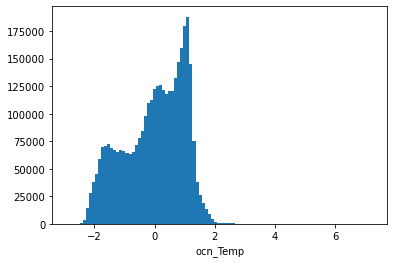

In [50]:
xn(train_features.ocn_Temp).plot.hist(bins=100);

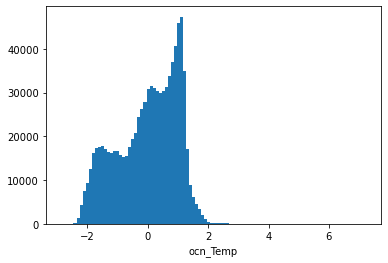

In [51]:
xn(test_features.ocn_Temp).plot.hist(bins=100);

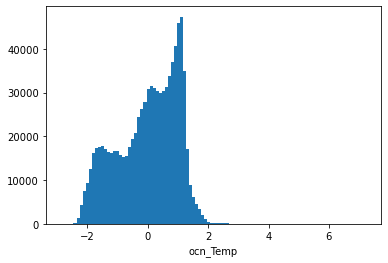

In [53]:
(
    (test_features.ocn_Temp - train_features.ocn_Temp.mean('sample')) /
    train_features.ocn_Temp.std('sample')
).plot.hist(bins=100);

Well, it's not very normal, but I guess we'll see how this goes

### Normalize the inputs

For now, bring them into memory...

In [54]:
%%time
dims = 'sample'
train_features_eager = {}
test_features_eager = {}

for key in ['ocn_Temp','ocn_MLD','atm_T','atm_speed_surf']:
    normalizer = XNormalizer(dims=dims)
    normalizer.adapt(train_features[key].load())
    
    train_features_eager[key] = normalizer(train_features[key]).load();
    test_features_eager[key] = normalizer(test_features[key]).load();

CPU times: user 28.4 s, sys: 3.48 s, total: 31.8 s
Wall time: 26.7 s


### Bring labels into memory too...

In [55]:
%%time
train_labels = train_labels.load();
train_labels = train_labels.load();

CPU times: user 27.2 s, sys: 3.15 s, total: 30.4 s
Wall time: 23.7 s


## Create the model

For vector valued input (e.g. `ocn_Temp`), keras wants this to be organized with the vector as the last dimension, hence the reordering of dimensions earlier

Create each input layer

In [56]:
ocn_temp_input = keras.Input(
    shape=(len(ds.olev),), name="ocn_Temp"
)
ocn_mxl_input = keras.Input(
    shape=(1,), name="ocn_MLD"
)
atm_temp_input = keras.Input(
    shape=(len(ds.alev),), name='atm_T'
)
atm_spd_input = keras.Input(
    shape=(1,), name='atm_speed_surf'
)

Then merge it all together

In [57]:
merge = keras.layers.concatenate(
    [ocn_temp_input, ocn_mxl_input, atm_temp_input, atm_spd_input]
)

For now, using merged vertical coordinate

In [96]:
output = keras.layers.Dense(
    units=len(train_labels.z), name="ao_corr",
    #kernel_regularizer=keras.regularizers.L1(1e-3)
    #kernel_regularizer=keras.regularizers.L1L2(5e-4,5e-4)
    kernel_regularizer=keras.regularizers.L2(1e-3)
)(merge)

In [97]:
model = keras.Model(
    inputs=[ocn_temp_input, ocn_mxl_input, atm_temp_input, atm_spd_input],
    outputs=[output]
)

In [98]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ocn_Temp (InputLayer)          [(None, 44)]         0           []                               
                                                                                                  
 ocn_MLD (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_T (InputLayer)             [(None, 74)]         0           []                               
                                                                                                  
 atm_speed_surf (InputLayer)    [(None, 1)]          0           []                               
                                                                                            

Size is bias vector + matrix ... good

In [99]:
74*44 + 120*(74*44)

393976

### Determine optimization process and train it

For now, use MSE loss function and Adam optimization.
Options in [keras regression losses](https://keras.io/api/losses/regression_losses/)
and [keras optimizers](https://keras.io/api/optimizers/) 

- What learning rate to use?
- What regularization type and parameter to use?
- How to do this in parallel rather than pulling everything into memory here?

In [100]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.05 #no idea on hyper parameters)
    ),
    loss=keras.losses.MeanSquaredError()
)

In [101]:
%%time
history = model.fit(
    x={k:train_features_eager[k].values for k in chosen_ones}, 
    y=train_labels.values,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
124/124 [==============================] - 3s 21ms/step - loss: 0.6666 - val_loss: 0.0031
Epoch 2/20
124/124 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 8/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 9/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 10/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0103 - val_lo

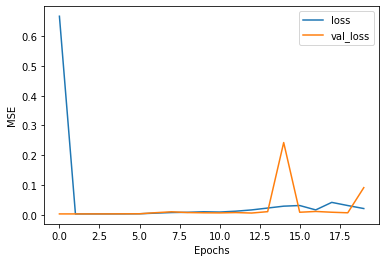

In [102]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

Without regularization, this loss curve looked like a random process. Now it's actually (mostly) decreasing.

In [103]:
model.evaluate(
    x={k:test_features_eager[k].values for k in chosen_ones}, 
    y=test_labels.values
)

619/619 [==============================] - 2s 3ms/step - loss: 0.0919


0.0918506607413292

In [104]:
prediction = model.predict({k:test_features_eager[k].values for k in test_features.data_vars if 'mask' not in k})

619/619 [==============================] - 1s 1ms/step


In [105]:
xpred = xr.DataArray(prediction,coords=test_labels.coords, dims=test_labels.dims)

In [106]:
xpred = xpred.unstack('z')

[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

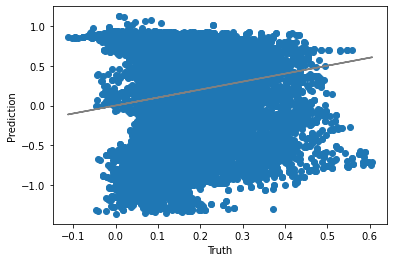

In [108]:
fig, ax = plt.subplots()
ax.scatter(test_labels.unstack('z').isel(alev=-1,olev=0),
           xpred.isel(alev=-1,olev=0),
          )
ax.plot(test_labels.unstack('z').isel(alev=-1,olev=0),test_labels.unstack('z').isel(alev=-1,olev=0),color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

💩